##  Simple RNN

### Load data

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

np.random.seed(1)
tf.random.set_seed(1)

In [15]:
X_test = pd.read_csv('data/bb_test_X.csv')
y_test = pd.read_csv('data/bb_test_y.csv')
X_train = pd.read_csv('data/bb_train_X.csv')
y_train = pd.read_csv('data/bb_train_y.csv')

## Data Transformation

In [16]:
#Target variables need to be an array with integer type
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [17]:
#Check the first 10 values of the train_y data set
y_train[0:10]

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [18]:
#Convert input variables to a 2-D array with float data type
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [19]:
X_train.shape

(861, 36)

In [24]:
X_train[1].shape

(36,)

In [25]:
#Keras expects a different input format:
#Data needs to have 3 dimensions

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
X_train[1].shape

(36, 1)

In [27]:
X_train.shape, y_train.shape

((861, 36, 1), (861, 1))

In [28]:
X_train

array([[[ -3.],
        [ -3.],
        [ -2.],
        ...,
        [ -5.],
        [ -3.],
        [ -7.]],

       [[  0.],
        [  1.],
        [ -1.],
        ...,
        [ 10.],
        [ 12.],
        [ 15.]],

       [[ -3.],
        [ -2.],
        [ -2.],
        ...,
        [ 14.],
        [ 12.],
        [ 12.]],

       ...,

       [[  2.],
        [  6.],
        [  8.],
        ...,
        [ -2.],
        [  1.],
        [  0.]],

       [[ -2.],
        [  1.],
        [ -1.],
        ...,
        [-19.],
        [-21.],
        [-14.]],

       [[  2.],
        [  1.],
        [  3.],
        ...,
        [  0.],
        [  2.],
        [  4.]]], dtype=float32)

# Simple RNN with one layer

In [30]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32,input_shape =(36,1)),
    keras.layers.Dense(1, activation ='sigmoid')
])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)

# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

history = model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

Epoch 1/50
27/27 [==============================] - 3s 15ms/step - loss: 0.4815 - accuracy: 0.7677 - val_loss: 0.3996 - val_accuracy: 0.8157
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 0.4217 - accuracy: 0.8037 - val_loss: 0.4077 - val_accuracy: 0.8049
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 0.4118 - accuracy: 0.8002 - val_loss: 0.3913 - val_accuracy: 0.8103
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 0.4111 - accuracy: 0.8072 - val_loss: 0.3953 - val_accuracy: 0.8130
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: 0.4278 - accuracy: 0.7921 - val_loss: 0.3905 - val_accuracy: 0.8211
Epoch 6/50
27/27 [==============================] - 0s 6ms/step - loss: 0.4144 - accuracy: 0.7979 - val_loss: 0.3965 - val_accuracy: 0.8103
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: 0.4176 - accuracy: 0.8037 - val_loss: 0.3889 - val_accuracy: 0.8238
Epoch 8/50
27/27 [=

In [32]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)

[0.40403062105178833, 0.8157181739807129]

In [33]:
# extract the accuracy from model.evaluate
print(f"{model.metrics_names[0]:s}: {scores[0]:.2f}")
print(f"{model.metrics_names[1]:s}: {scores[1]*100:.2f}")

loss: 0.40
accuracy: 81.57


In [37]:
# Predictions are probabilities.
y_pred = model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test,np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       167
           1       0.81      0.86      0.84       202

    accuracy                           0.82       369
   macro avg       0.82      0.81      0.81       369
weighted avg       0.82      0.82      0.81       369



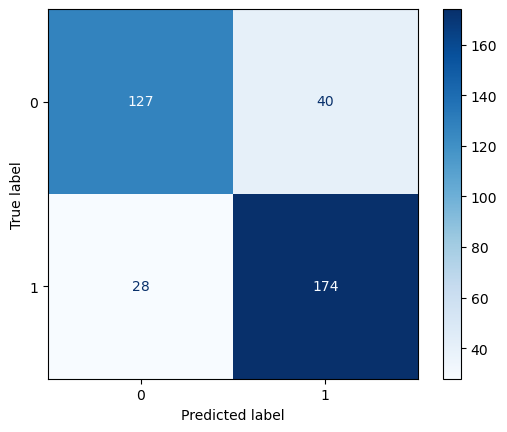

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
c = confusion_matrix(y_test, np.round(y_pred))
disp = ConfusionMatrixDisplay(c)
disp.plot(cmap='Blues')

# Deep RNN

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training.**

**Since the last layer is DENSE, it can't take sequence data. Therefore, you CANNOT return sequences from the previous layer. So, remove** `return_sequences` **from previous layer.**

In [44]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[n_steps, n_inputs] ),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32), 
    keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Nadam(learning_rate=0.01)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data = (X_test, y_test), 
    callbacks=[early_stop])  # we defined this early_stop callback function earlier

Epoch 1/20
27/27 [==============================] - 2s 29ms/step - loss: 0.4855 - accuracy: 0.7782 - val_loss: 0.4030 - val_accuracy: 0.8211
Epoch 2/20
27/27 [==============================] - 0s 18ms/step - loss: 0.4503 - accuracy: 0.7735 - val_loss: 0.4768 - val_accuracy: 0.7588
Epoch 3/20
27/27 [==============================] - 0s 18ms/step - loss: 0.4523 - accuracy: 0.7816 - val_loss: 0.4166 - val_accuracy: 0.8157
Epoch 4/20
27/27 [==============================] - 0s 18ms/step - loss: 0.4307 - accuracy: 0.7851 - val_loss: 0.3916 - val_accuracy: 0.8076
Epoch 5/20
27/27 [==============================] - 1s 20ms/step - loss: 0.4070 - accuracy: 0.7967 - val_loss: 0.4077 - val_accuracy: 0.8022
Epoch 6/20
27/27 [==============================] - 1s 19ms/step - loss: 0.4025 - accuracy: 0.8014 - val_loss: 0.4091 - val_accuracy: 0.7995
Epoch 7/20
27/27 [==============================] - 1s 19ms/step - loss: 0.3981 - accuracy: 0.8095 - val_loss: 0.3835 - val_accuracy: 0.8374
Epoch 8/20
27

In [46]:
# evaluate the model

scores = model.evaluate(X_test, y_test, verbose=0)

scores
# In results, first is loss, second is accuracy

[0.45239052176475525, 0.7696477174758911]

In [47]:
# extract the accuracy from model.evaluate
print(f"{model.metrics_names[0]:s}: {scores[0]:.2f}")
print(f"{model.metrics_names[1]:s}: {scores[1]*100:.2f}")

loss: 0.45
accuracy: 76.96


In [48]:
# Predictions are probabilities.
y_pred = model.predict(X_test)

12/12 [==============================] - 0s 5ms/step


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       167
           1       0.79      0.79      0.79       202

    accuracy                           0.77       369
   macro avg       0.77      0.77      0.77       369
weighted avg       0.77      0.77      0.77       369



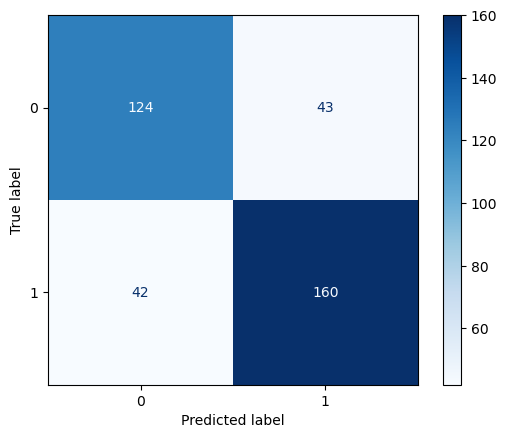

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
c = confusion_matrix(y_test, np.round(y_pred))
disp = ConfusionMatrixDisplay(c)
disp.plot(cmap='Blues')